In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [13]:
cnl_spd = pd.read_csv('channel_spend_student_data.csv', names=['tier', 'channel']).dropna()
cnl_spd

,tier,channel
1,tier1,"{'email': 1000.0, 'social': 1000.0000000000001..."
2,tier2,"{'email': 2000.0, 'social': 2000.0, 'display':..."
3,tier3,"{'email': 3000.0, 'social': 3000.0, 'display':..."


In [14]:
att_alloc = pd.read_csv('attribution_allocation_student_data.csv')
att_alloc = att_alloc[att_alloc.convert_TF == True]
att_alloc

,convert_TF,touch1,touch2,touch3,touch4,touch5,tier
0,True,referral,referral,referral,email,NaN,1
1,True,referral,display,display,email,NaN,1
2,True,email,display,referral,NaN,NaN,1
3,True,referral,referral,email,NaN,NaN,1
4,True,social,referral,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...
60648,True,referral,referral,referral,NaN,NaN,3
60649,True,display,referral,NaN,NaN,NaN,3
68103,True,organic_search,referral,paid_search,NaN,NaN,3
68104,True,organic_search,display,NaN,NaN,NaN,3


# 3 Methods for Allocation


## First Interaction, Last Interaction, Linear

In [15]:
spend_dict = {1: 5000, 2: 10000, 3: 15000}
att_alloc['spend'] = att_alloc.tier.map(spend_dict)
att_alloc

,convert_TF,touch1,touch2,touch3,touch4,touch5,tier,spend
0,True,referral,referral,referral,email,NaN,1,5000
1,True,referral,display,display,email,NaN,1,5000
2,True,email,display,referral,NaN,NaN,1,5000
3,True,referral,referral,email,NaN,NaN,1,5000
4,True,social,referral,NaN,NaN,NaN,1,5000
...,...,...,...,...,...,...,...,...
60648,True,referral,referral,referral,NaN,NaN,3,15000
60649,True,display,referral,NaN,NaN,NaN,3,15000
68103,True,organic_search,referral,paid_search,NaN,NaN,3,15000
68104,True,organic_search,display,NaN,NaN,NaN,3,15000


In [16]:
num_conversion = att_alloc.shape[0]

In [17]:
first_int = att_alloc.groupby(['touch1'])['convert_TF'].sum()/num_conversion

filled_att = att_alloc.T.ffill().T
last_int = filled_att.groupby(['touch5'])['convert_TF'].sum()/num_conversion

In [18]:
first_int

touch1
direct            0.000435
display           0.147398
email             0.093185
organic_search    0.001089
paid_search       0.048480
referral          0.543944
social            0.165469
Name: convert_TF, dtype: float64

In [19]:
last_int

touch5
direct            0.000508
display            0.16634
email             0.108208
organic_search    0.000798
paid_search       0.072865
referral          0.436461
social             0.21482
Name: convert_TF, dtype: object

In [20]:
linear_int = att_alloc.iloc[:, 1:6].T \
    .apply(pd.Series.value_counts, args = (True, True, False, None, True)) \
    .sum(axis=1)/num_conversion
linear_int

direct            0.000537
display           0.145835
email             0.092539
organic_search    0.001172
paid_search       0.051155
referral          0.541682
social            0.167079
dtype: float64

In [21]:
total_int = pd.concat([first_int, last_int, linear_int], axis=1)
total_int.columns = ['first', 'last', 'linear']
total_int

,first,last,linear
direct,0.000435,0.000508,0.000537
display,0.147398,0.16634,0.145835
email,0.093185,0.108208,0.092539
organic_search,0.001089,0.000798,0.001172
paid_search,0.048480,0.072865,0.051155
referral,0.543944,0.436461,0.541682
social,0.165469,0.21482,0.167079


Text(0.5, 1.0, 'Conversion rate')

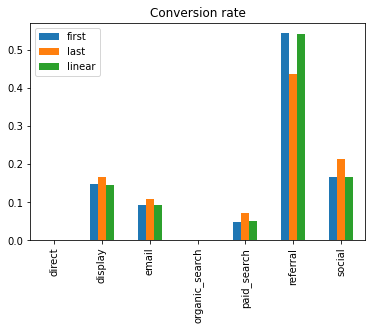

In [22]:
total_int.plot.bar()
plt.title('Conversion rate')

## Average CAC

In [23]:
tier1 = ast.literal_eval(cnl_spd.iloc[0, 1])
tier2 = ast.literal_eval(cnl_spd.iloc[1, 1])
tier3 = ast.literal_eval(cnl_spd.iloc[2, 1])

In [24]:
tier1_cost = pd.DataFrame(tier1.values(), index=tier1.keys(), columns=['cost'])
tier2_cost = pd.DataFrame(tier2.values(), index=tier2.keys(), columns=['cost'])
tier3_cost = pd.DataFrame(tier3.values(), index=tier3.keys(), columns=['cost'])

cost = pd.concat([tier1_cost, tier2_cost, tier3_cost], axis=1).sum(axis=1)
cost

email             6000.0
social            6000.0
display           6000.0
paid_search       6000.0
referral          6000.0
organic_search       0.0
direct               0.0
dtype: float64

In [25]:
CAC = 6000/(total_int * num_conversion)
CAC.loc['direct', :], CAC.loc['organic_search', :] = 0, 0

CAC

,first,last,linear
direct,0.000000,0,0.000000
display,2.954210,2.617801,2.985867
email,4.672897,4.024145,4.705513
organic_search,0.000000,0,0.000000
paid_search,8.982036,5.976096,8.512248
referral,0.800534,0.997672,0.803876
social,2.631579,2.027027,2.606222


Text(0.5, 1.0, 'CAC for each Channel')

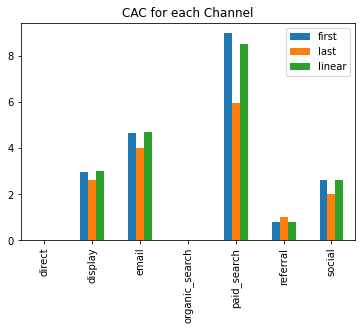

In [26]:
CAC.plot.bar()
plt.title('CAC for each Channel')

# I choose LINEAR to calculate marginal CAC
## To calculate, we need to investigate how CAC change w.r.t tiers (1, 2, 3)

In [27]:
att1 = att_alloc[att_alloc['tier'] == 1]
att2 = att_alloc[att_alloc['tier'] == 2]
att3 = att_alloc[att_alloc['tier'] == 3]


In [28]:
conv1 = att1.iloc[:, 1:6].T \
    .apply(pd.Series.value_counts, args = (True, True, False, None, True)) \
    .sum(axis=1)
conv2 = att2.iloc[:, 1:6].T \
    .apply(pd.Series.value_counts, args = (True, True, False, None, True)) \
    .sum(axis=1)
conv3 = att3.iloc[:, 1:6].T \
    .apply(pd.Series.value_counts, args = (True, True, False, None, True)) \
    .sum(axis=1)

conv_by_tier = pd.concat([conv1, conv2, conv3], axis=1)
conv_by_tier.columns = ['tier1', 'tier2', 'tier3']
conv_by_tier

,tier1,tier2,tier3
direct,1.916667,2.066667,3.416667
display,439.266667,724.083333,846.116667
email,251.133333,442.516667,581.450000
organic_search,1.950000,6.466667,7.733333
paid_search,128.050000,237.816667,339.000000
referral,1517.100000,2656.683333,3290.050000
social,484.583333,822.366667,995.233333


In [29]:
CAC_marginal = pd.DataFrame()
CAC_marginal['tier1'] = 1000/conv_by_tier['tier1']
CAC_marginal['tier2'] = 1000/(conv_by_tier['tier2'] - conv_by_tier['tier1'])
CAC_marginal['tier3'] = 1000/(conv_by_tier['tier3'] - conv_by_tier['tier2'])

CAC_marginal.loc['direct', :] = 0
CAC_marginal.loc['organic_search', :] = 0

CAC_marginal

,tier1,tier2,tier3
direct,0.000000,0.000000,0.000000
display,2.276521,3.511030,8.194482
email,3.981949,5.225115,7.197697
organic_search,0.000000,0.000000,0.000000
paid_search,7.809449,9.110234,9.883051
referral,0.659152,0.877514,1.578864
social,2.063629,2.960478,5.784805


Text(0.5, 1.0, 'Marginal CAC for each tier')

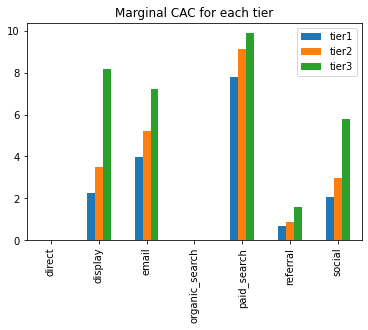

In [31]:
CAC_marginal.plot.bar()
plt.title('Marginal CAC for each tier')